In our project, we explored the impact of the "Titanic" movie by conducting an analysis in three distinct areas:

* **Film Review Emotion Analysis**: Here, we evaluated the emotional responses of viewers by analyzing the sentiment expressed in film reviews.

* **Word Frequency Analysis of Film Reviews**: This part involved a detailed examination of the language used in the reviews. By analyzing the top frequency of words, we gained insights into the common themes and descriptive terms associated with viewers' perceptions of the movie.

* **Film Review Trends Forecast**: In this final section, we looked at the trends in film reviews over time. By analyzing past and current review data, we aimed to forecast future sentiment trends, providing an outlook on how the movie's reception might evolve and be perceived by future audiences.












## **Sentimental Analysis**



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import pandas as pd
from transformers import pipeline
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

file_path = './imdb_reviews_unique.csv'
reviews_df = pd.read_csv(file_path)

sentiment_model = pipeline("sentiment-analysis", truncation=True)

def analyze_sentiment(title, review):
    full_text = title + ". " + review
    sentences = sent_tokenize(full_text)
    scores = []

    for sentence in sentences:
        max_length = 512
        parts = [sentence[i:i + max_length] for i in range(0, len(sentence), max_length)]

        for part in parts:
            if part.strip() != '':
                result = sentiment_model(part)[0]
                scores.append(result['score'] if result['label'] == 'POSITIVE' else 1 - result['score'])

    return sum(scores) / len(scores) if scores else 0

reviews_df['Sentiment_Score'] = reviews_df.apply(lambda x: analyze_sentiment(x['Title'], x['Review']), axis=1)

reviews_df.head()

output_path = "/content/Sentiment_Score.csv"
reviews_df.to_csv(output_path, index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Read a processed, high-quality dataset called imdb_reviews_unique.csv. The data set has five variables: Title, Author, Date, and Review. The title stands for the main idea of the film review. The author indicates who wrote the review. The date is the time when the writer wrote the film review. The review is a review of a movie written by a writer. The trained Hugging Face Transformers were used to calculate the combined reviews' title and movie reviews to obtain a text-based sentiment score. Hugging Face Transformers is pre-trained on a large corpus of text to allow the model to learn the semantic representation of the text, capturing the relationships between different words through a self-attention mechanism. Hugging Face Transformers implements the basic Transformer model and various pre-trained models such as BERT, GPT, T5, etc., which perform well on specific NLP tasks and can perform specific tasks such as text classification or sentiment analysis. The calculated sentiment scores are merged with the original data set into a new CSV file called Sentiment_Score. The sentiment score is on a scale of 0 to 1, with 0 being extremely negative and 1 being extremely positive.



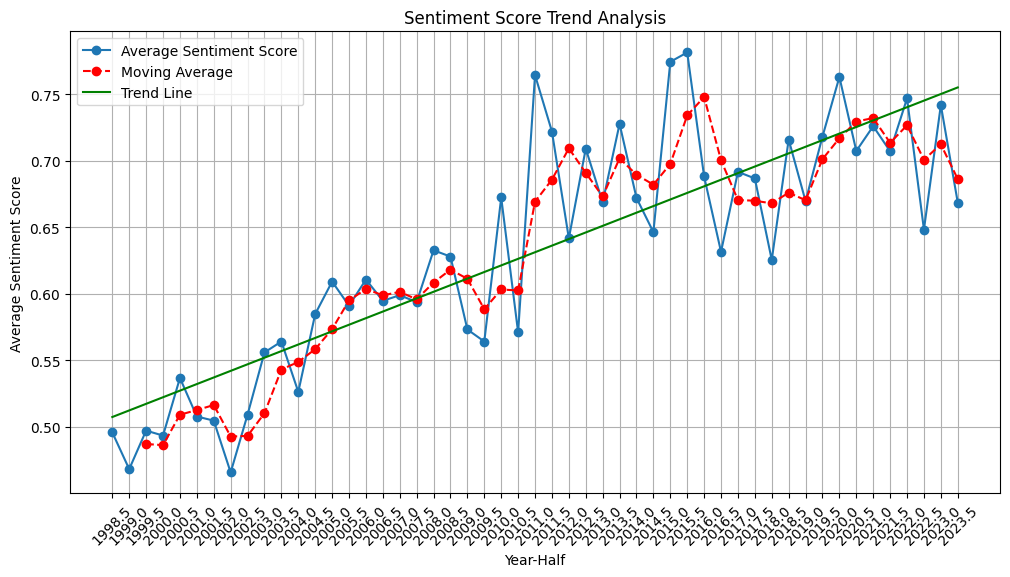

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

reviews_df = pd.read_csv('/content/Sentiment_Score.csv')
reviews_df['Date'] = pd.to_datetime(reviews_df['Date'])

reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

score_by_time['Moving_Avg'] = score_by_time['Sentiment_Score'].rolling(window=3).mean()

X = score_by_time['Year-Half_Numeric'].values.reshape(-1, 1)
y = score_by_time['Sentiment_Score'].values

model = LinearRegression().fit(X, y)
score_by_time['Trend'] = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Sentiment_Score'], marker='o', label='Average Sentiment Score')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Moving_Avg'], marker='o', linestyle='--', color='red', label='Moving Average')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Trend'], linestyle='-', color='green', label='Trend Line')

plt.xticks(score_by_time['Year-Half_Numeric'], rotation=45)
plt.xlabel('Year-Half')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Score Trend Analysis')
plt.legend()
plt.grid(True)
plt.show()

The calculated emotion score was analyzed visually. Each half year is a range, and each field takes the average of the sentiment scores of different users during that period. .5 represents the second half of the year, and .0 represents the first half. Visualizations record an overall upward trend in sentiment scores from the second half of 1998 to the second half of 2023.


Correlation Matrix:
                              Transformed_Sentiment_Score    Rating
Transformed_Sentiment_Score                     1.000000  0.757396
Rating                                          0.757396  1.000000

Spearman Correlation Coefficient:  0.7055647694706387
Spearman P-value:  2.1264551409578257e-181

Descriptive Statistics:
        Transformed_Sentiment_Score       Rating
count                  1200.000000  1200.000000
mean                      6.383814     7.029167
std                       2.624475     3.484983
min                       1.002166     1.000000
25%                       4.233460     4.000000
50%                       6.760628     9.000000
75%                       8.589163    10.000000
max                       9.998989    10.000000


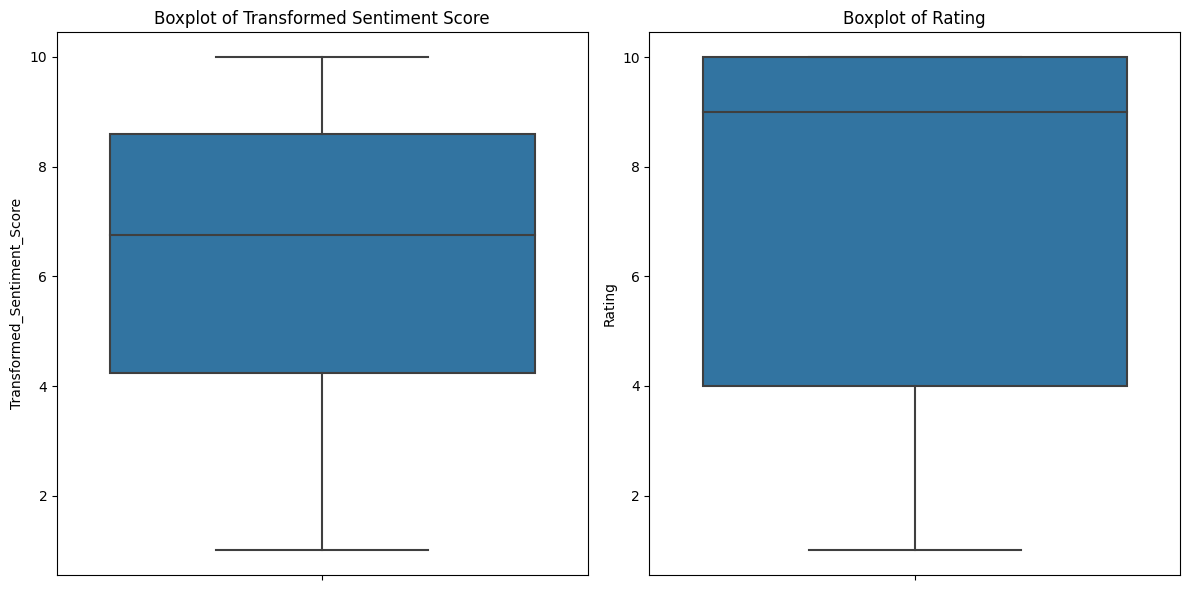

In [22]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

reviews_df_path = '/content/Sentiment_Score.csv'
imdb_reviews_path = '/content/imdb_reviews_rating.csv'

reviews_df = pd.read_csv(reviews_df_path)
imdb_reviews = pd.read_csv(imdb_reviews_path)

merged_df = pd.merge(reviews_df, imdb_reviews[['Author', 'Rating']], on='Author', how='left')

merged_df = merged_df[merged_df['Rating'] != 'No Rating']
merged_df.dropna(subset=['Rating'], inplace=True)

merged_df['Rating'] = merged_df['Rating'].str.split('/').str[0]
merged_df['Rating'] = pd.to_numeric(merged_df['Rating'], errors='coerce')

merged_df['Transformed_Sentiment_Score'] = (merged_df['Sentiment_Score'] * 9)+1

transformed_correlation = merged_df[['Transformed_Sentiment_Score', 'Rating']].corr()

spearman_corr_transformed, spearman_p_value_transformed = stats.spearmanr(merged_df['Transformed_Sentiment_Score'], merged_df['Rating'], nan_policy='omit')

print("Correlation Matrix:\n", transformed_correlation)
print("\nSpearman Correlation Coefficient: ", spearman_corr_transformed)
print("Spearman P-value: ", spearman_p_value_transformed)

print("\nDescriptive Statistics:\n", merged_df[['Transformed_Sentiment_Score', 'Rating']].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=merged_df, y='Transformed_Sentiment_Score')
plt.title('Boxplot of Transformed Sentiment Score')

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_df, y='Rating')
plt.title('Boxplot of Rating')

plt.tight_layout()
plt.show()


The sentiment score maps from the interval 0 to 1 to the same interval as the rating, which is 1 to 10. Then, statistical analysis was conducted to compare the converted sentiment score and rating. The Spearman P-value is close to 0, and the Spearman Correlation Coefficient is 0.71, indicating that the Sentiment Score calculated based on film reviews is strongly positively correlated with people's active rating. This further verifies the validity of the calculated Sentiment Score. However, since they are not always consistent, it also highlights the limitation of sentimental analysis, the subjectivity of user ratings, cultural differences, etc. For example, some people think that Titanic is a great movie, but they do not write reviews with gorgeous words, resulting in the sentimental scores calculated based on film reviews slightly lower than people's subjective rating. An individual's extreme rating may also be a factor.

## **Word Frequency**

In this section, we worked on the word frequency analysis for negative and positive reviews, for all reviews from 1998-2003, we choose sentimental scores >0.8 as positive review analysis, and sentimental scores <0.2 as negative reviews.  

In [23]:
!pip install spacy==2.3.5
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 30.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached thinc-7.4.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached srsly-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (369 kB)
  Using cached catalogue-1.0.2-py2.py3-none-any.whl (16 kB)
  Using cached plac-1.1.3-py2.py3-none-any.whl (20 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for spacy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for spacy
Failed to build spacy
ERROR: Could not build wheels for spacy, which is required to install pyp

In [55]:
reviews_df['Date'] = pd.to_datetime(reviews_df['Date'])
reviews_df['Year'] = reviews_df['Date'].dt.year

Top 20 negative reviews over years



In [56]:
# Filter the DataFrame
df_negative = reviews_df[reviews_df['Sentiment_Score'] < 0.2]

In [57]:
import spacy
import string

nlp = spacy.load("en_core_web_sm")

exclude_words = set(['see', 'go','bad','know', 'story', 'film', 'titanic', 'movie', 'good', 'watch', 'ship', 'like', 'love','people','time','think','look','thing','want','make','mean','find','get','well','way','great','truely','completely','james'])

def clean_text(text):
    doc = nlp(text.lower())
    cleaned_text = []

    for token in doc:
        lemma = token.lemma_
        if lemma not in exclude_words and not token.is_stop and not token.is_punct and not token.is_digit:
            cleaned_text.append(lemma)
    return " ".join(cleaned_text)
df_negative['Cleaned_Review'] = df_negative['Review'].apply(clean_text)

In [58]:
from collections import Counter
words = [word for review in df_negative['Cleaned_Review'] for word in review.split()]
word_frequencies = Counter(words)
most_common_words = word_frequencies.most_common(20)
most_common_words

[('cameron', 144),
 ('effect', 133),
 ('character', 115),
 ('sink', 97),
 ('hour', 94),
 ('special', 93),
 ('jack', 87),
 ('kate', 73),
 ('scene', 71),
 ('winslet', 69),
 ('dicaprio', 69),
 ('class', 65),
 ('rise', 64),
 ('real', 63),
 ('oscar', 62),
 ('acting', 61),
 ('plot', 60),
 ('life', 57),
 ('hate', 55),
 ('girl', 55)]

Top 20 positive reviews over years

In [59]:
df_positive = reviews_df[reviews_df['Sentiment_Score'] > 0.8]
df_positive['Cleaned_Review'] = df_positive['Review'].apply(clean_text)

In [60]:
words = [word for review in df_positive['Cleaned_Review'] for word in review.split()]
word_frequencies = Counter(words)
most_common_words = word_frequencies.most_common(20)
most_common_words

[('cameron', 596),
 ('jack', 566),
 ('rise', 467),
 ('kate', 455),
 ('winslet', 435),
 ('dicaprio', 367),
 ('life', 336),
 ('character', 327),
 ('leonardo', 326),
 ('feel', 309),
 ('scene', 297),
 ('heart', 281),
 ('year', 256),
 ('romance', 253),
 ('effect', 249),
 ('amazing', 240),
 ('beautiful', 236),
 ('actor', 228),
 ('real', 204),
 ('end', 195)]

Here is our conclusion:

For negative reviews:
1. frequent references to 'Cameron' and terms like 'effect', 'special', and 'scene' suggest critiques focused on the directorial choices and the film's visual and special effects.

2. Words like 'character', 'Jack', 'Kate', 'Winslet', 'DiCaprio', and 'acting' suggest that many negative reviews focus on the characters and their portrayal. The specific mention of lead actors indicates that viewers' opinions about their performances are significant points of discussion.

3. Words like 'sink', 'rise', 'real', and 'class' indicate discussions about historical accuracy, realism, and the portrayal of the Titanic's sinking. This suggests that viewers critique how the film handles historical events and social dynamics.

4. The word 'hour'  refer to the film's duration, indicating that some viewers found the movie too long or poorly paced.

For positive reviews:

1. In contrast, for positive reviews, the high frequency of actor and characters’ names and the word “performance” indicates reviewers’ strong appreciation for the story and actors’ acting.

2. Words like 'feel', 'heart', and 'romance' point to the emotional impact of the film, with 'beautiful' indicating a positive response to the movie's aesthetic and emotional elements.

3. Rise', 'life', and 'end' might relate to the storyline and thematic elements, implying that the narrative arc and its conclusion resonated positively with viewers.


---



Analyzing the top frequency words in 5-year segments:

In [61]:
for start_year in range(df_negative['Year'].min(), df_negative['Year'].max(), 5):
    end_year = start_year + 4
    segment_df = df_negative[(df_negative['Year'] >= start_year) & (df_negative['Year'] <= end_year)]
    aggregated_tokens = [word for review in segment_df['Cleaned_Review'] for word in review.split()]
    top_words = Counter(aggregated_tokens).most_common(5)
    print(f"Top words for {start_year}-{end_year}: {top_words}")

Top words for 1998-2002: [('effect', 92), ('character', 83), ('cameron', 82), ('special', 68), ('hour', 50)]
Top words for 2003-2007: [('cameron', 33), ('jack', 30), ('rise', 29), ('sink', 29), ('kate', 27)]
Top words for 2008-2012: [('action', 11), ('effect', 10), ('real', 10), ('awful', 10), ('sink', 9)]
Top words for 2013-2017: [('cameron', 11), ('scene', 7), ('awful', 4), ('kate', 4), ('long', 4)]
Top words for 2018-2022: [('jack', 20), ('life', 14), ('star', 14), ('sink', 12), ('rise', 11)]


In the early days of a film, audiences paid more attention to novel special effects and character development, which were the main criteria for evaluating the film. Over time, however, audiences began to evaluate the film more deeply and pay more attention to the style of the director, the depth of the story, and the complexity of the characters.

In [62]:
for start_year in range(df_positive['Year'].min(), df_positive['Year'].max(), 5):
    end_year = start_year + 4
    segment_df = df_positive[(df_positive['Year'] >= start_year) & (df_positive['Year'] <= end_year)]
    aggregated_tokens = [word for review in segment_df['Cleaned_Review'] for word in review.split()]
    top_words = Counter(aggregated_tokens).most_common(5)
    print(f"Top words for {start_year}-{end_year}: {top_words}")

Top words for 1998-2002: [('cameron', 134), ('winslet', 87), ('kate', 85), ('dicaprio', 72), ('jack', 65)]
Top words for 2003-2007: [('jack', 148), ('kate', 118), ('winslet', 115), ('cameron', 115), ('rise', 108)]
Top words for 2008-2012: [('jack', 114), ('cameron', 107), ('rise', 96), ('winslet', 71), ('kate', 65)]
Top words for 2013-2017: [('jack', 101), ('rise', 98), ('cameron', 59), ('kate', 58), ('character', 52)]
Top words for 2018-2022: [('cameron', 115), ('kate', 101), ('jack', 86), ('winslet', 86), ('leonardo', 79)]


Over time, character nouns and actors' names appear more frequently in positive words, which may reflect the audience's emotional connection to the characters and continued recognition of the actors' performances.

## **Future trend prediction**

From the original plot we can see that there is a upward trend for sentiment score and there are some irregularities. From the code below we can see that the data is not stationay; therefore we need to differenciate and apply seasonal decomposition first.

In [32]:
from statsmodels.tsa.stattools import adfuller
reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Perform Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(score_by_time['Sentiment_Score'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:', adf_result[4])

ADF Statistic: -1.7773551358974677
p-value: 0.3917607707596086
Critical Values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


After differenciate and apply seasonal decomposition, we can see that the residual is stationary, since the p value is lower than critical value (0.05)

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
score_by_time['Sentiment_Score'] = score_by_time['Sentiment_Score'].astype(float)
# Reset index before differencing
score_by_time.reset_index(drop=True, inplace=True)

# Apply differencing
score_by_time['Differenced'] = score_by_time['Sentiment_Score'].diff(1).dropna()

reviews_df['Year-Half_Numeric'] = reviews_df['Year-Half_Numeric'].astype(str)
reviews_df['Date'] = pd.to_datetime(reviews_df['Year-Half_Numeric'], format='%Y.%f')
# Set 'Date' as the index
reviews_df.set_index('Date', inplace=True)
# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()
# Perform seasonal decomposition
decomposition = seasonal_decompose(score_by_time['Sentiment_Score'], period=4)
residual = decomposition.resid.dropna()

# Perform Augmented Dickey-Fuller test for stationarity
adf_result_residual = adfuller(residual)
print(f'ADF Statistic: {adf_result_residual[0]}')
print(f'p-value: {adf_result_residual[1]}')
print('Critical Values:', adf_result_residual[4])

ADF Statistic: -4.483319784291208
p-value: 0.00021074636204390805
Critical Values: {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}


Here we generate the ACF and PACF graph to select the ARIMA model that is appropriate for the data. After seasonal decomposition and differencing, we plotted the ACF and PACF plots for the resulted data. The ACF plot indicated that we should choose q = 1 since the ACF value stands out side the significance level. Moreover, by observing the PACF plot, we can choose p = 1,2. In conclusion, we should fit our data with ARIMA(1,1,1) model or ARIMA(1,1,2).

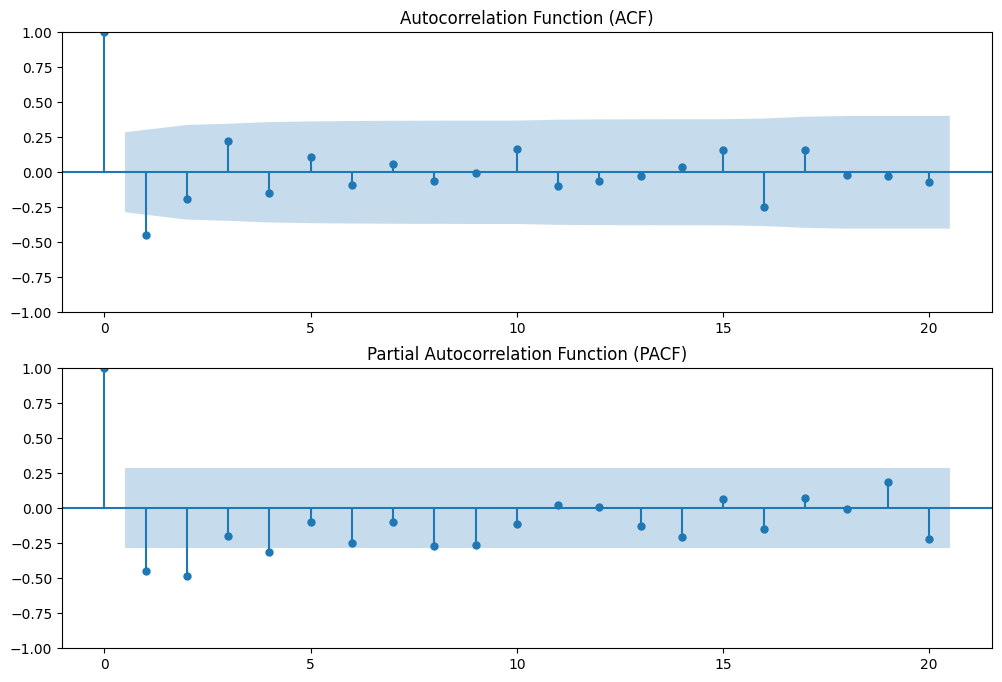

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(residual, ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(residual, ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1,1,1))
results = model.fit(disp=False)

# Get the AIC
aic = results.aic
print(f'AIC: {aic}')

AIC: -153.09753224012215


In [36]:
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1,1,2))
results = model.fit(disp=False)

# Get the AIC
aic = results.aic
print(f'AIC: {aic}')

AIC: -151.21852777497844


Since AIC for order (1,1,1) is lower, we chose p = 1, q = 1, d=1 for our model.

Below graph help us to determine the seasonal order. By looking at the graph

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) for Seasonal Differences')

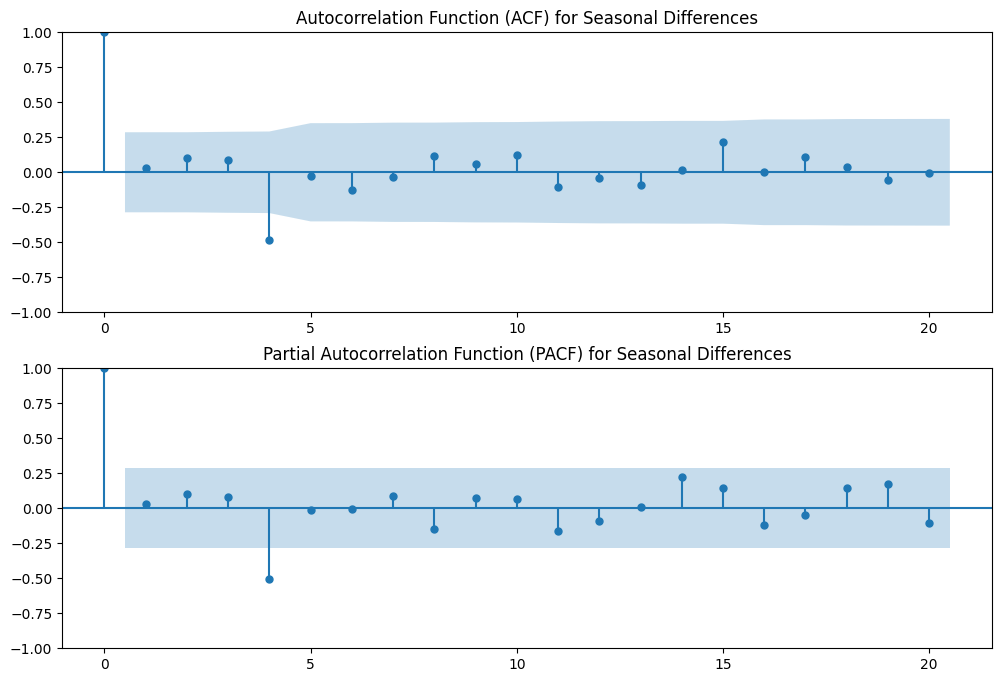

In [37]:
# Calculate seasonal differences (assuming a seasonal period of 6)
seasonal_diff = score_by_time['Sentiment_Score'].diff(4).dropna()

# Plot ACF and PACF for seasonal differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(seasonal_diff, ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF) for Seasonal Differences')

# PACF plot
plot_pacf(seasonal_diff, ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF) for Seasonal Differences')


The ACF and PACF plots show the autocorrelation of a time series that has been seasonally differenced at lag 4. This differencing suggests that the seasonality in the data is expected to occur every four time periods. The plots are used to determine the seasonal components of an ARIMA model, typically denoted as (P, D, Q)s, where 's' is the seasonality period. In this case, 's' would be 4.

Both ACF and PACF plots show correlations that are not clearly significant after the first lag, suggesting that the seasonal autoregressive (P) and seasonal moving average (Q) components might both be 0 or 1. Therefore we look at the AIC to determine the final model. and the result shows that seasonal_order 1,1,1,4 would be more appropriate.


In [38]:
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1,1,1), seasonal_order=(1,1,1,4))
results = model.fit(disp=False)

# Get the AIC
aic = results.aic
print(f'AIC: {aic}')

AIC: -128.18592430748117


In [39]:
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1,1,1), seasonal_order=(0,1,0,4))
results = model.fit(disp=False)

# Get the AIC
aic = results.aic
print(f'AIC: {aic}')

AIC: -112.37124469789404


We use the SARIMA (1,1,1) with seasonal order (1,1,1,4) to predict future trend of the sentiment score for the next 5 years.

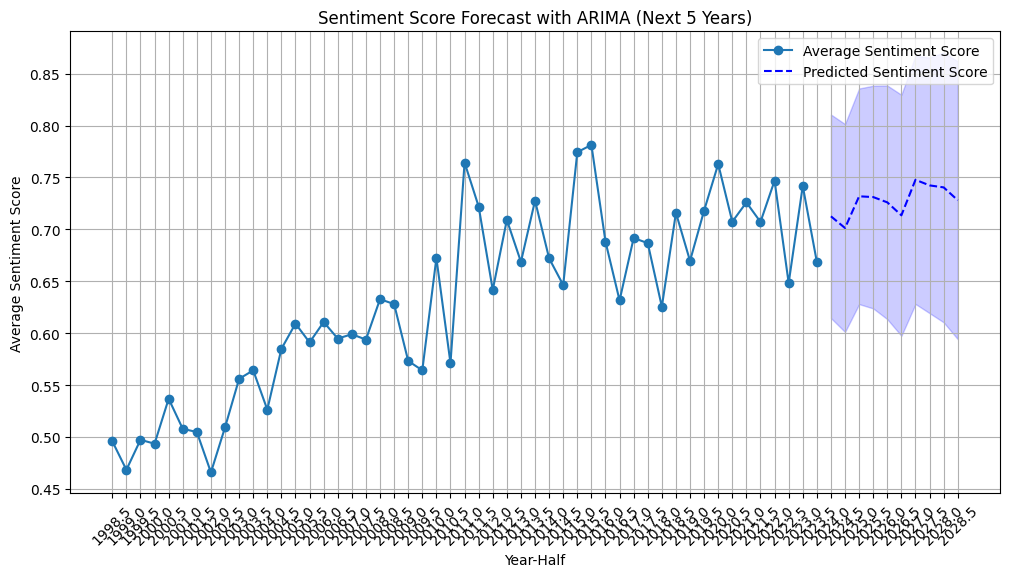

In [40]:

reviews_df = pd.read_csv('/content/Sentiment_Score.csv')
reviews_df['Date'] = pd.to_datetime(reviews_df['Date'])
# Assuming 'Date' column is in datetime format
reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Fit ARIMA model
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1, 1, 1), seasonal_order=(1,1,1,4))
results = model.fit(disp=False)

# Predict sentiment scores for the next 5 years (10 half-years)
future_years = np.arange(score_by_time['Year-Half_Numeric'].max() + 0.5, score_by_time['Year-Half_Numeric'].max() + 5.5, 0.5)
future_predictions = results.get_forecast(steps=len(future_years))
predicted_mean = future_predictions.predicted_mean
confidence_interval = future_predictions.conf_int()

# Add future predictions to the DataFrame
future_df = pd.DataFrame({'Year-Half_Numeric': future_years, 'Predicted_Sentiment_Score': predicted_mean.values})
score_by_time = pd.concat([score_by_time, future_df], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Sentiment_Score'], marker='o', label='Average Sentiment Score')
plt.plot(score_by_time['Year-Half_Numeric'], score_by_time['Predicted_Sentiment_Score'], linestyle='--', color='blue', label='Predicted Sentiment Score')

# Plot confidence interval (optional)
plt.fill_between(future_years, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='blue', alpha=0.2)

plt.xticks(score_by_time['Year-Half_Numeric'], rotation=45)
plt.xlabel('Year-Half')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Score Forecast with ARIMA (Next 5 Years)')
plt.legend()
plt.grid(True)
plt.show()

From the plot we can see that there is a over all upward trend for future 5 years with minor fluctuate. Since we used the half year mean, the prediction may not be as acurate but can be used as reference.

Here it gives the 95% CI for each half year of the future that we are predicting.

In [41]:
# Assuming 'Date' column is in datetime format
reviews_df['Year-Half_Numeric'] = reviews_df['Date'].apply(lambda x: x.year + (0.5 if x.month > 6 else 0))

# Group by 'Year-Half_Numeric' and calculate the mean sentiment score
score_by_time = reviews_df.groupby('Year-Half_Numeric')['Sentiment_Score'].mean().reset_index()

# Fit ARIMA model
model = SARIMAX(score_by_time['Sentiment_Score'], order=(1, 1, 1), seasonal_order=(1,1,1,4))
results = model.fit(disp=False)

# Predict sentiment scores for the next 5 years (10 half-years)
future_years = np.arange(score_by_time['Year-Half_Numeric'].max() + 0.5, score_by_time['Year-Half_Numeric'].max() + 5.5, 0.5)
future_predictions = results.get_forecast(steps=len(future_years))
predicted_mean = future_predictions.predicted_mean
confidence_interval = future_predictions.conf_int()

# Create a DataFrame with predictions and confidence interval
prediction_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Sentiment_Score': predicted_mean.values,
    'Lower_Bound': confidence_interval.iloc[:, 0].values,
    'Upper_Bound': confidence_interval.iloc[:, 1].values
})
print(prediction_df)

     Year  Predicted_Sentiment_Score  Lower_Bound  Upper_Bound
0  2024.0                   0.712561     0.614538     0.810584
1  2024.5                   0.701298     0.601164     0.801432
2  2025.0                   0.731842     0.628007     0.835677
3  2025.5                   0.731091     0.623845     0.838338
4  2026.0                   0.726001     0.613472     0.838530
5  2026.5                   0.713526     0.597428     0.829623
6  2027.0                   0.747738     0.628115     0.867360
7  2027.5                   0.742340     0.619304     0.865376
8  2028.0                   0.740417     0.610445     0.870388
9  2028.5                   0.728020     0.594211     0.861829


The results for the Titanic movie's sentiment scores over the years 2024 to 2028.5 show a consistent, generally positive sentiment trend with some fluctuations.

The consistently positive sentiment scores suggest that the Titanic movie continues to resonate positively with audiences. This enduring appeal is significant for a film released decades ago, indicating its timeless quality and continued relevance.

#### Potential Business Value

- The reproduction of classic event type films
- Improving products or services: Consumer preference insights, segmentation strategies based on group subjectivity
- Risk management: Timely detection of negative sentiment and low ratings in comments can serve as a crisis warning.
- Companies can manage their brand reputation more effectively by analyzing public sentiment and evaluation
Analyzing trends in sentiment scores and ratings can help predict market trends and consumer behavior, providing a basis for strategic decisions
- By comparing the emotional scores and ratings of different movies or products, you can better understand the strengths and weaknesses of your competitors



#### Reference

- "Titanic Reviews & Ratings." IMDb, IMDb.com, 6 Dec. 2023, https://www.imdb.com/title/tt0120338/reviews.
- Hugging Face. "Transformers." Hugging Face, 2023, https://huggingface.co/transformers.
